In [11]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/NGD.jl")
include("../Inversion/IPS.jl")
include("../Inversion/Utility.jl")


cos_error_estimation_particle (generic function with 3 methods)

In [12]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

In [13]:
function Gaussian_density_helper(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( sqrt(det(θθ_cov)) )

end


function Gaussian_density(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( (2π)^(N_θ/2)*sqrt(det(θθ_cov)) )

end

function Gaussian_2d(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}; std=2,  N_p = 100) where {FT<:AbstractFloat}
    
    N_p = 100
    std = 2
    U, S, _ = svd(θθ_cov)
    xy_p  = [cos.(LinRange(0, 2*pi, N_p))  sin.(LinRange(0, 2*pi, N_p))]'

    xy_p = U * (std * sqrt.(S) .* xy_p) + θ_mean*ones(N_p)'

    return xy_p[1, :], xy_p[2, :]
end


function KL_estimator(m, C, func_log_rho_post; N_ens = 100)
    Random.seed!(42)
    
    N_θ = length(m)
    c_weights    =  rand(Normal(0, 1), N_θ, N_ens)
    # shift mean to and covariance to I
    c_weights -= dropdims(mean(c_weights, dims=2), dims=2)*ones(N_ens)'
    U1, S1, _ = svd(c_weights)
    c_weights = (S1/sqrt(N_ens - 1.0) .\U1') *  c_weights 

    chol_C = cholesky(Hermitian(C)).L
    xs = zeros(N_ens, N_θ)
    xs .= (m * ones(N_ens)' + chol_C * c_weights)'
    
    log_rho_posts = zeros(N_ens)
    for i = 1:N_ens
        log_rho_posts[i] = func_log_rho_post(xs[i,:])
    end
    return -1/2*log(det(C)) - sum(log_rho_posts)/N_ens
end


function log_Rosenbrock(θ,  ϵ)
    θ₁, θ₂ = θ
    return -ϵ*(θ₂ - θ₁^2)^2/20 - (1.0 - θ₁)^2/20  #+ log_prior(θ)
end

function compute_Eref(ϵ, ω, b)
    xx = Array(LinRange(-200.0, 200.0, 10^7))

    E1 = sum(exp.(-(1 .- xx).^2/20))
    Eθ₁²  = sum(xx.^2 .* exp.(-(1 .- xx).^2/20))  / E1
    Eθ₁θ₂ = sum(xx.^3 .* exp.(-(1 .- xx).^2/20))  /E1
    Eθ₂²  = sum((xx.^4 .+ 10/ϵ) .* exp.(-(1 .- xx).^2/20))     /E1
    Ecos = zeros(length(b))
    for i = 1:length(b)
        Ecos[i]  = sum(cos.(ω[i,2]*xx.^2 + ω[i,1]*xx .+ b[i]).* exp.(-(1 .- xx).^2/20))/exp(5/ϵ*ω[i,2]^2) /E1
    end

    return [1.0;11.0], [Eθ₁²-1.0 Eθ₁θ₂-11.0; Eθ₁θ₂-11.0 Eθ₂²-121.0], Ecos 
end

compute_Eref (generic function with 1 method)

## Rosenbrock banana likelihood function

We will explore the question with the following inverse problem 

$$
\mathcal{G}(\theta) 
=
\begin{bmatrix}
\theta_{(2)} - \theta_{(1)}^2\\
\theta_{(1)}
\end{bmatrix} 
\qquad
\theta_{ref} = 
\begin{bmatrix}
1\\
1
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_{\eta_1}^2 & 0\\
0 & \sigma_{\eta_2}^2
\end{bmatrix} 
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the "uninformative" Gaussian prior $\mathcal{N}(0, 10^2 I)$.
     

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/dzhuang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[14]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[14]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[14]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[14]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[14]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[14]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[14]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[14]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[14]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[14]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[14]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[14]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[14]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[14]:64
┌ Info: ("finish "

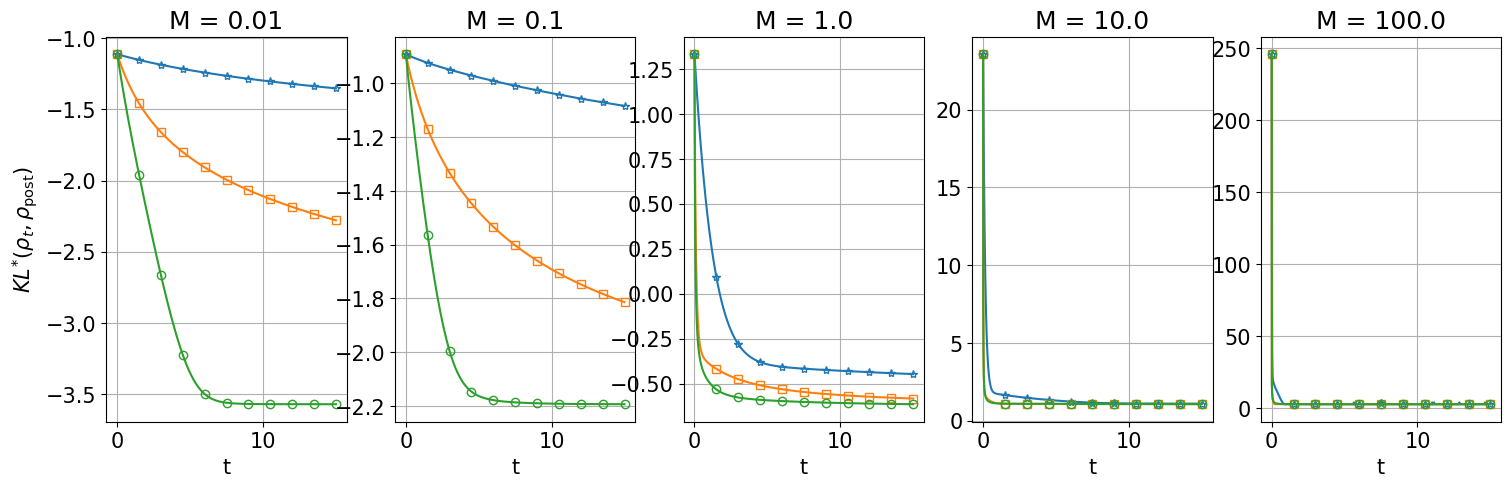

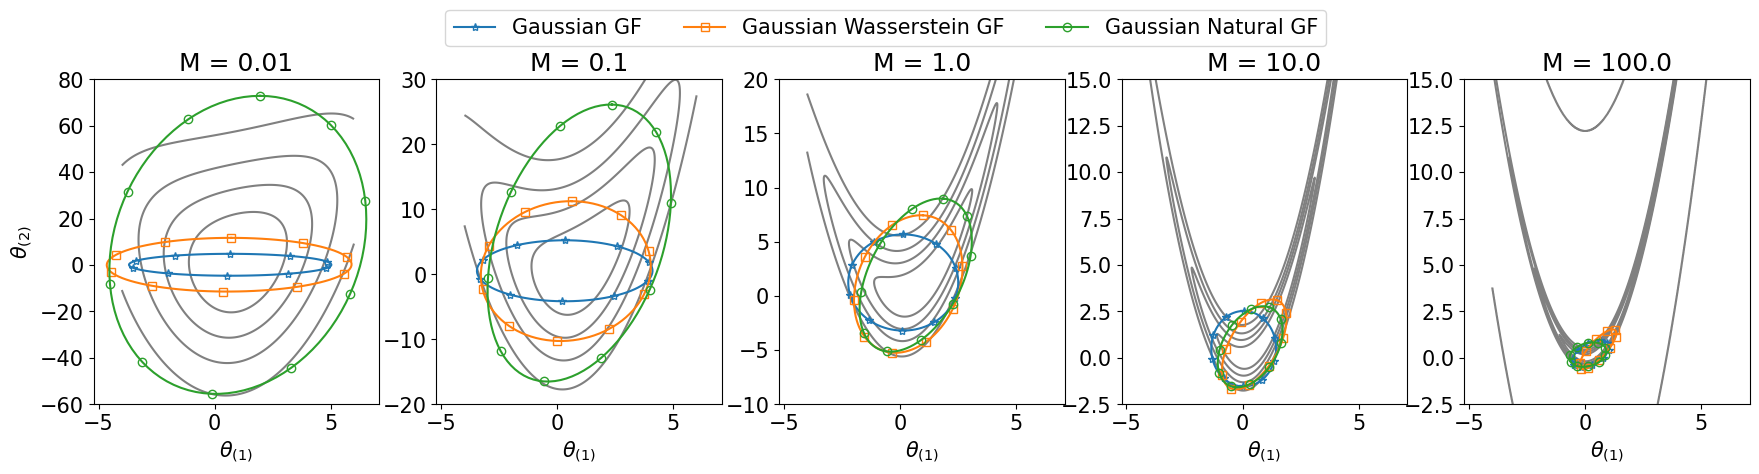

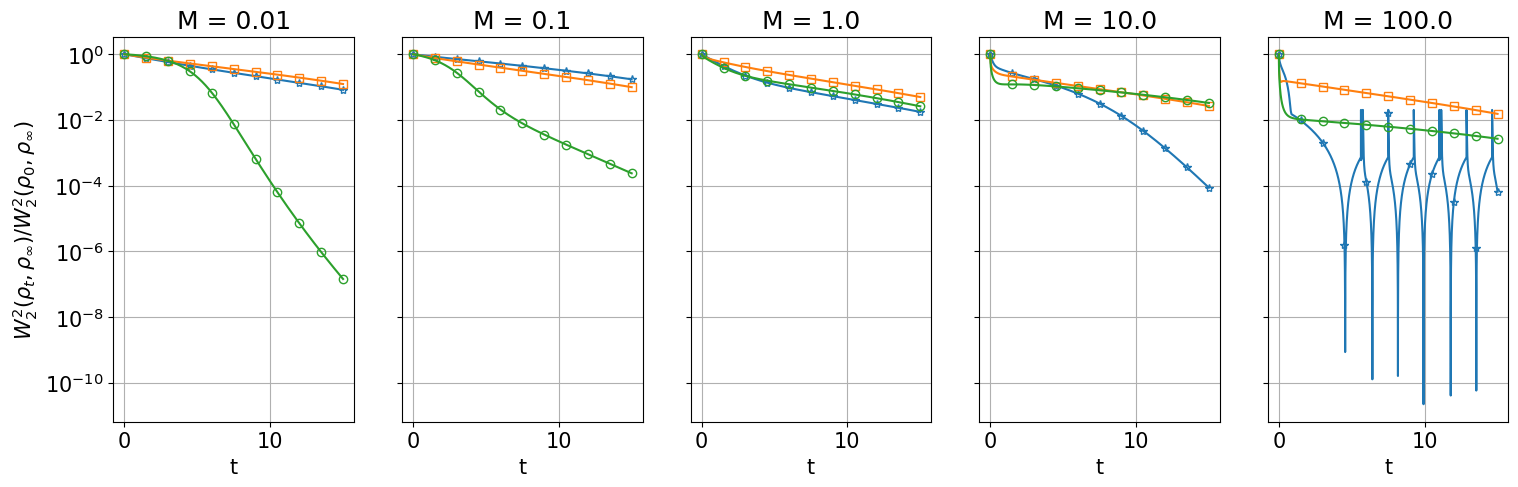

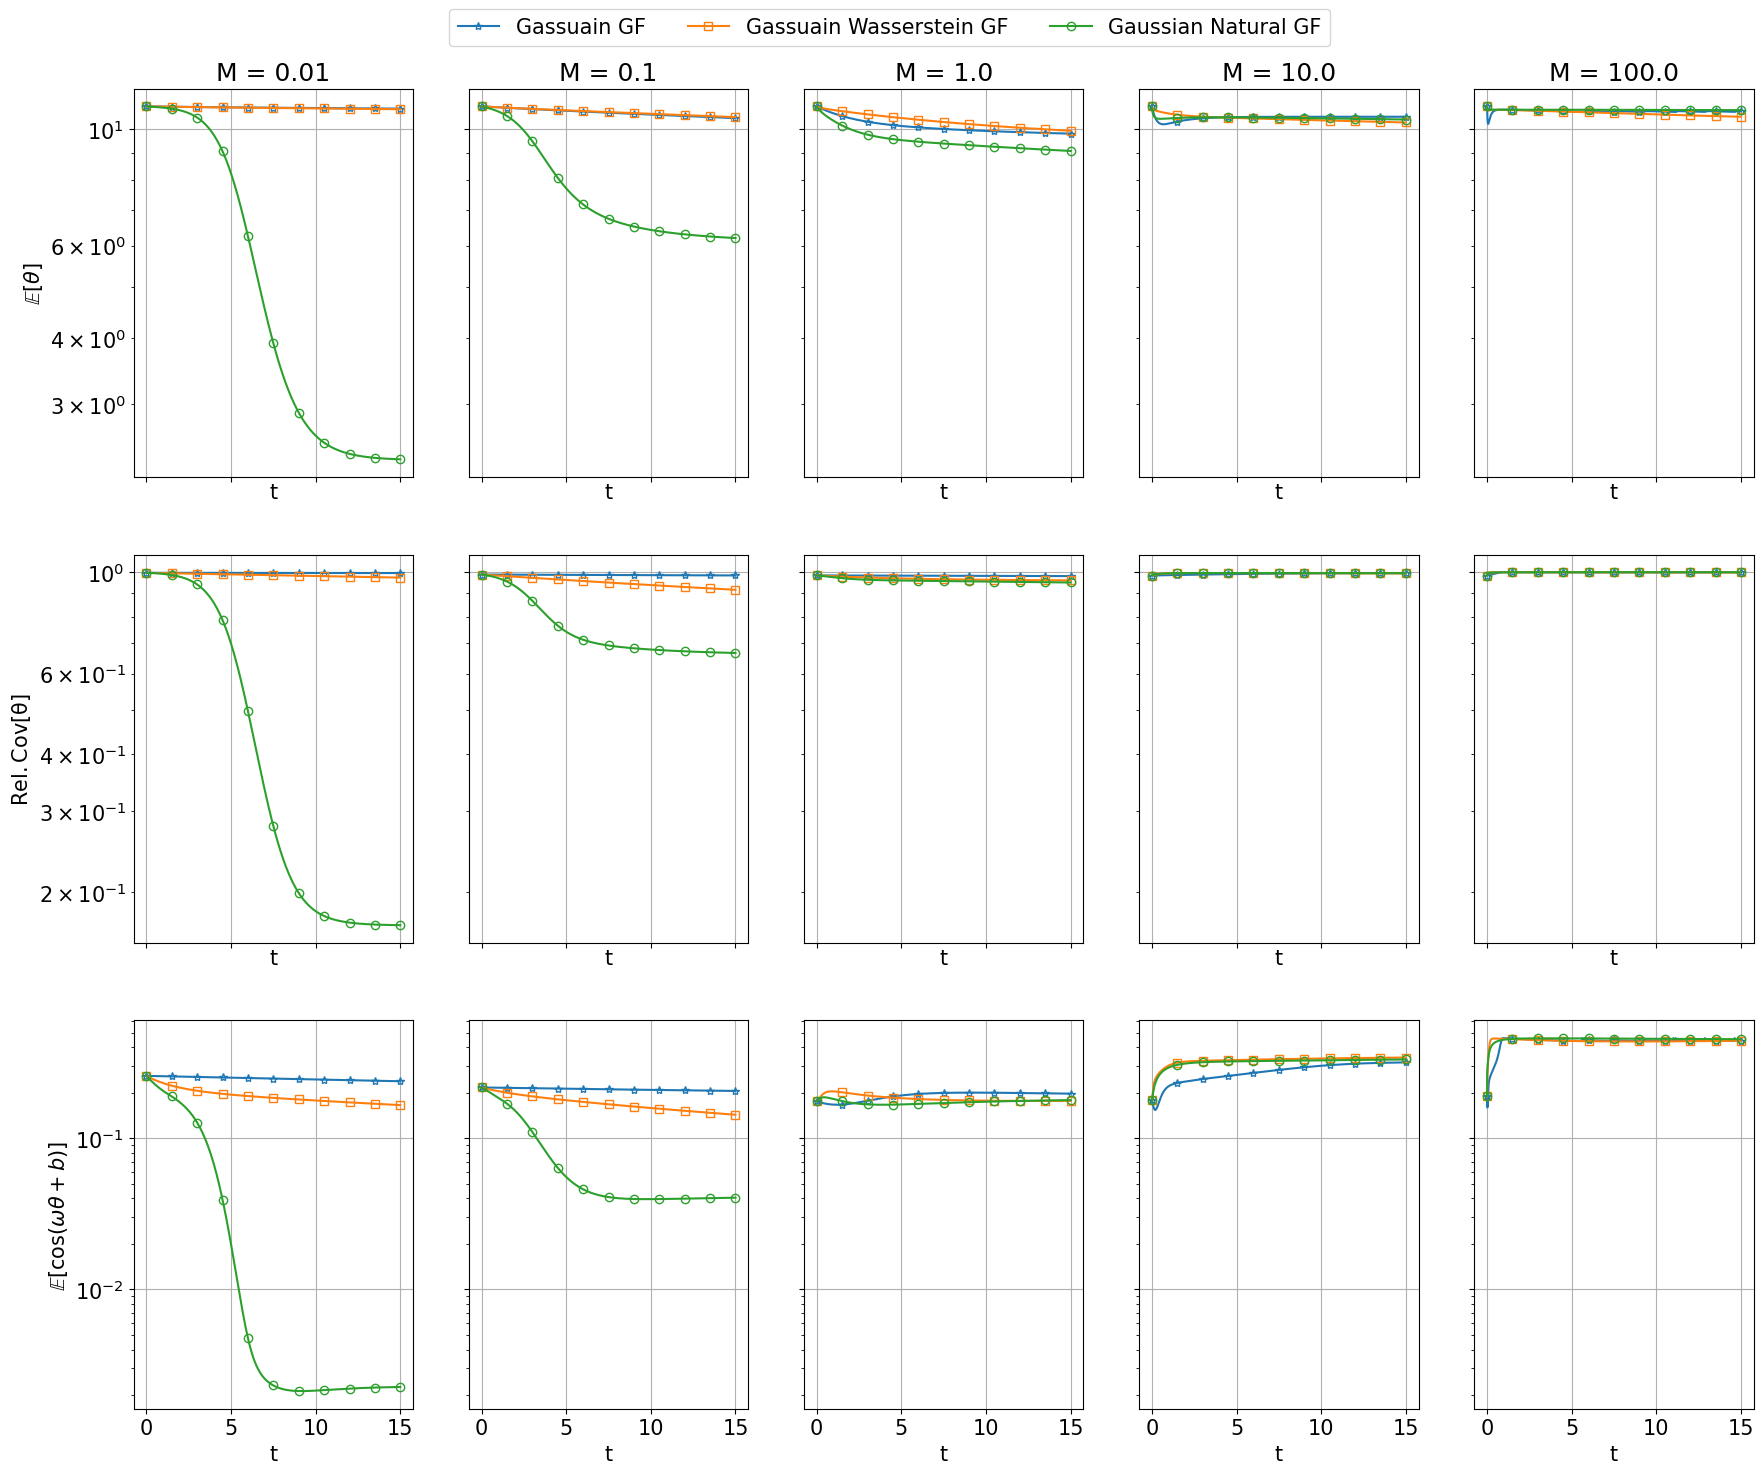

In [14]:
Random.seed!(42)


ϵs = [0.01, 0.1, 1, 10, 100] 
fig_err, ax_err = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_converge, ax_converge = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))
fig_conv, ax_conv = PyPlot.subplots(ncols=5, nrows=3, sharex=true, sharey="row", figsize=(18,15))

y_ranges = [[-60,80],[-20,30],[-10, 20],[-2.5, 15],[-2.5, 15]]

μ0, σ0 = [0.0;0.0], 2
Σ0 = [σ0^2 0.0;0.0  σ0^2]
y = [0.0; 1.0]

ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
for test_id = 1:length(ϵs)
    

    logρ(θ) = log_Rosenbrock(θ,  ϵs[test_id])

    function compute_Φ(s_param, θ) 
        Φ   =  -logρ(θ)
        dΦ  =  -ForwardDiff.gradient(logρ, θ)
        ddΦ =  -ForwardDiff.hessian(logρ, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = -4.0, 6.0
    y_min, y_max = y_ranges[test_id]
    N_x, N_y = 1000, 1000
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = logρ( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, length(y)+N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 1000
    Δt = 0.001
    N_t_tot = 30000
    
    
    compute_gradient = true
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_t = div(N_t_tot, 2)
    N_p=100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_t], gd_obj.θθ_cov[N_t]; std = 3, N_p=N_p)
    ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gaussian GF")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_t], wgd_obj.θθ_cov[N_t])
    ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Gaussian Wasserstein GF")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_t], ngd_obj.θθ_cov[N_t])
    ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Gaussian Natural GF")
    ax_scatter[test_id].set_title("M = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_scatter[test_id].set_ylabel(L"\theta_{(2)}")
    end
    ax_scatter[test_id].set_xlabel(L"\theta_{(1)}")
    
    e_gd = zeros(N_t+1)
    e_wgd = zeros(N_t+1)
    e_ngd = zeros(N_t+1)
    for i = 1:N_t+1
        e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i], logρ)  
        e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], logρ)  
        e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], logρ)  
    end
    
    ts = Array(0:N_t) * Δt
    markevery = div(N_t,10)
    ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gradient descent")
    ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Wasserstein gradient descent")
    ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Natural gradient descent")
    ax_err[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    
#     if test_id == length(ϵs)
#         ax_err[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    
    ekl_gd, ekl_ngd, ekl_wgd = zeros(N_t+1),  zeros(N_t+1),  zeros(N_t+1)
    for i = 1:N_t+1
        
        
        m_oo, C_oo = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * ngd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_oo)^2 + tr(ngd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
        
        m_oo, C_oo = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * gd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_oo)^2 + tr(gd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )


        m_oo, C_oo = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * wgd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_oo)^2 + tr(wgd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    ekl_wgd ./= ekl_wgd[1]
    ekl_gd  ./= ekl_gd[1]
    ekl_ngd ./= ekl_ngd[1]
    
    ts = Array(0:N_t) * Δt
    markevery = div(N_t,10)
    ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Wasserstein gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Natural gradient descent")
    ax_converge[test_id].set_title("M = " * string(ϵs[test_id]))    
    if test_id ==1
        ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
    end
    ax_converge[test_id].set_xlabel("t")
    ax_converge[test_id].grid("on")

    
    m_oo, C_oo, cos_ref = compute_Eref(ϵs[test_id], ω, b)
    gd_errors    = zeros(N_t+1, 3)
    ngd_errors    = zeros(N_t+1, 3)
    wgd_errors    = zeros(N_t+1, 3)
    for i = 1:N_t+1
        m_i, C_i = gd_obj.θ_mean[i], gd_obj.θθ_cov[i]
        gd_errors[i, 1]  = norm(m_i .- m_oo)
        gd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        gd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i]
        ngd_errors[i, 1]  = norm(m_i .- m_oo)
        ngd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        ngd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i]
        wgd_errors[i, 1]  = norm(m_i .- m_oo)
        wgd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        wgd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
    end
    markevery=div(N_t, 10)
    ax_conv[1, test_id].semilogy(ts, gd_errors[:, 1],  "-*", fillstyle="none", label="Gassuain GF", markevery = markevery)
    ax_conv[1, test_id].semilogy(ts, wgd_errors[:, 1], "-s", fillstyle="none", label="Gassuain Wasserstein GF", markevery = markevery)
    ax_conv[1, test_id].semilogy(ts, ngd_errors[:, 1], "-o", fillstyle="none", label="Gaussian Natural GF", markevery = markevery)
            
    ax_conv[2, test_id].semilogy(ts, gd_errors[:, 2],  "-*", fillstyle="none", label="Gassuain GF", markevery = markevery)
    ax_conv[2, test_id].semilogy(ts, wgd_errors[:, 2], "-s", fillstyle="none", label="Gassuain Wasserstein GF", markevery = markevery)
    ax_conv[2, test_id].semilogy(ts, ngd_errors[:, 2], "-o", fillstyle="none", label="Gaussian Natural GF", markevery = markevery)
    
    ax_conv[3, test_id].semilogy(ts, gd_errors[:, 3],  "-*", fillstyle="none", label="Gassuain GF", markevery = markevery)
    ax_conv[3, test_id].semilogy(ts, wgd_errors[:, 3], "-s", fillstyle="none", label="Gassuain Wasserstein GF", markevery = markevery)
    ax_conv[3, test_id].semilogy(ts, ngd_errors[:, 3], "-o", fillstyle="none", label="Gaussian Natural GF", markevery = markevery)
    
    ax_conv[1, test_id].set_title("M = " * string(ϵs[test_id]))
    ax_conv[1, test_id].set_xlabel("t")
    ax_conv[2, test_id].set_xlabel("t")
    ax_conv[3, test_id].set_xlabel("t")
    
    ax_conv[1, test_id].grid("on")
    ax_conv[2, test_id].grid("on")
    ax_conv[3, test_id].grid("on")
end

handles, labels = ax_scatter[1,1].get_legend_handles_labels()
fig_scatter.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=5)
fig_scatter.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_scatter.savefig("Banana_gd_contour.pdf")


handles, labels = ax_conv[1,1].get_legend_handles_labels()
fig_conv.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=5)
ax_conv[1,1].set_ylabel(L"$\mathbb{E}[\theta]$")
ax_conv[2,1].set_ylabel(L"\rm{Rel. Cov}[\theta]")
ax_conv[3,1].set_ylabel(L"$\mathbb{E}[\cos(\omega\theta + b)]$")
fig_conv.subplots_adjust(bottom=0.05,top=0.93,left=0.08,right=0.98,hspace=0.2)
fig_conv.savefig("Banana_gd_converge.pdf")


In [5]:
handles, labels = ax_err[1].get_legend_handles_labels()
fig_err.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_err.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_err.savefig("Rosenbrock_gd_error.pdf")


handles, labels = ax_scatter[1].get_legend_handles_labels()
fig_scatter.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_scatter.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_scatter.savefig("Rosenbrock_gd_density.pdf")

handles, labels = ax_converge[1].get_legend_handles_labels()
fig_converge.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_converge.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_converge.savefig("Rosenbrock_gd_converge.pdf")






┌ Info: ("Wasserstein", " preconditioner ", false, " ϵ = ", 0.01)
└ @ Main In[18]:72
┌ Info: ("mean = ", [0.7131227195354726, 1.1422688620191244], " ", [1.0, 11.0])
└ @ Main In[18]:73
┌ Info: ("cov = ", [7.000722967847389 -0.5542340576556571; -0.5542340576556571 35.8536008913401], " ", [10.000000000000002 20.0; 20.0 1240.0])
└ @ Main In[18]:74
┌ Info: 171059.06862349063
└ @ Main In[18]:95
┌ Info: ("Wasserstein", " preconditioner ", true, " ϵ = ", 0.01)
└ @ Main In[18]:72
┌ Info: ("mean = ", [0.42270991024122284, 9.708105974819926], " ", [1.0, 11.0])
└ @ Main In[18]:73
┌ Info: ("cov = ", [7.524698071824822 15.124378142237328; 15.124378142237328 920.9434539714459], " ", [10.000000000000002 20.0; 20.0 1240.0])
└ @ Main In[18]:74
┌ Info: 79258.7972571407
└ @ Main In[18]:95
┌ Info: ("Stein", " preconditioner ", false, " ϵ = ", 0.01)
└ @ Main In[18]:72
┌ Info: ("mean = ", [0.7434219274400169, 0.809463315830759], " ", [1.0, 11.0])
└ @ Main In[18]:73
┌ Info: ("cov = ", [6.305648667080693 0.195

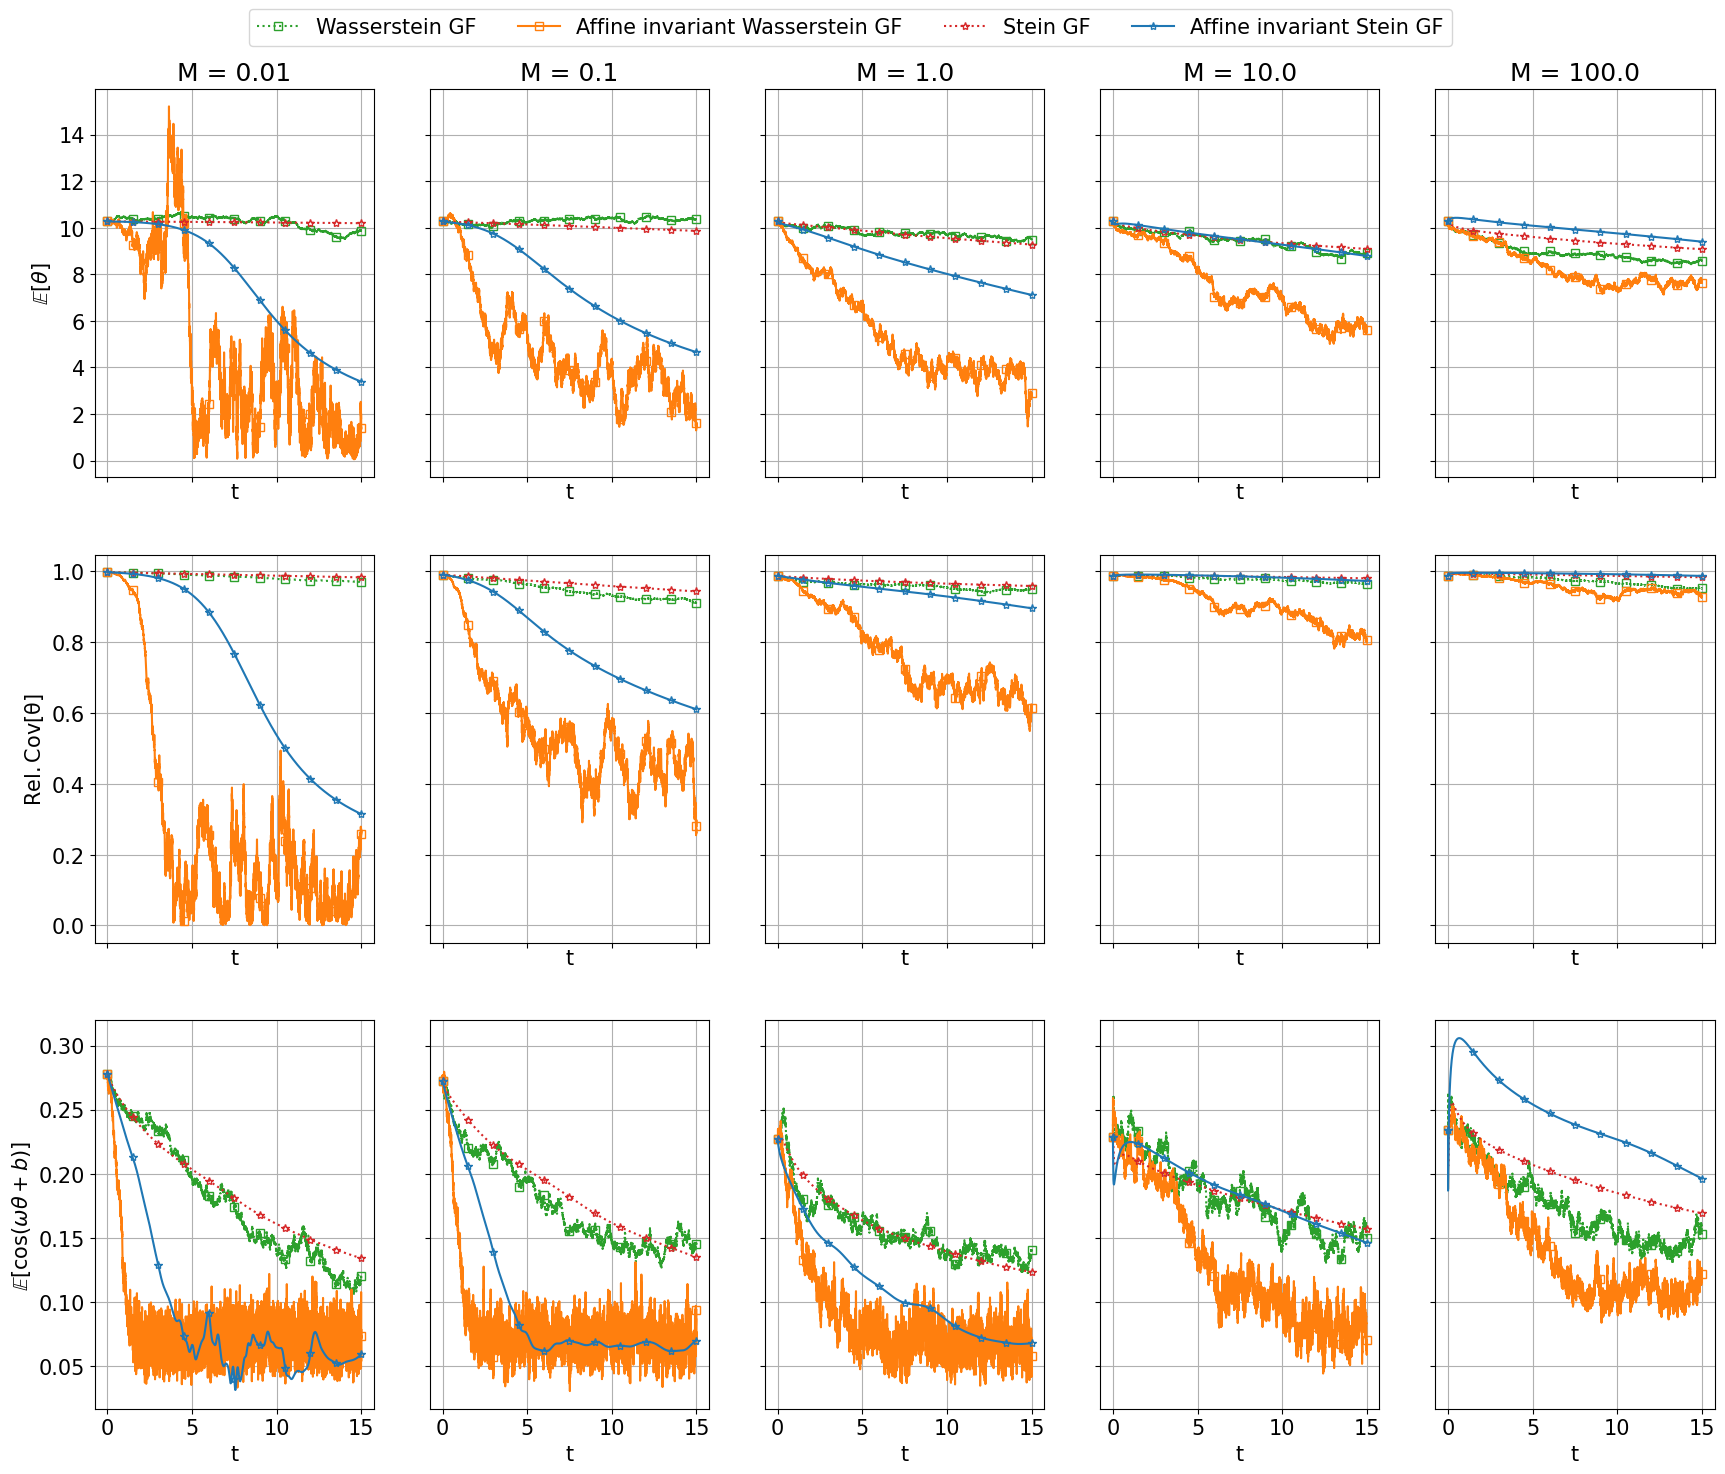

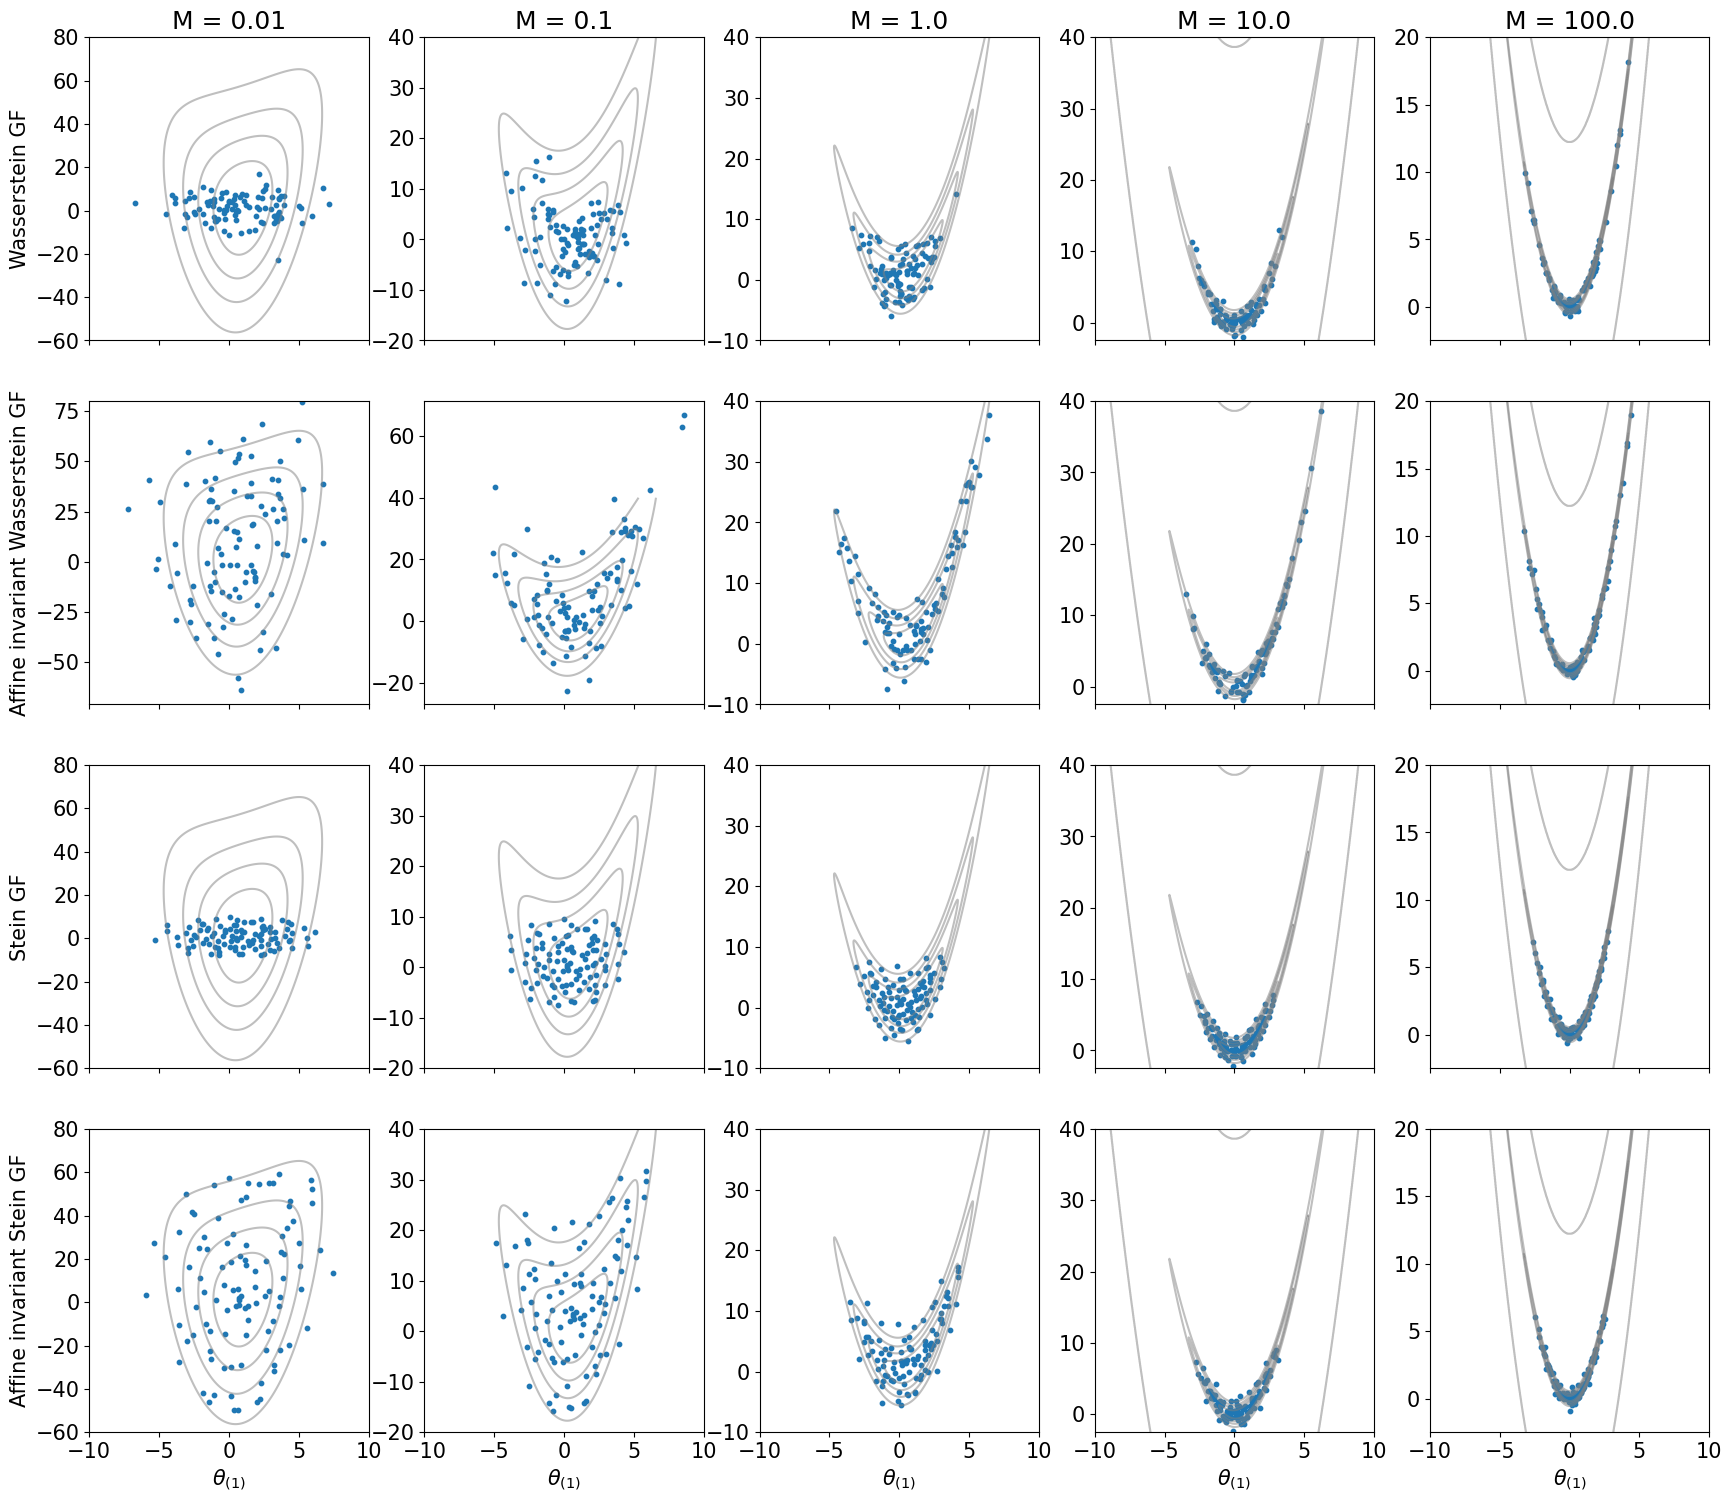

In [18]:

Random.seed!(42)
######################### TEST #######################################
N_θ = 2
m_0 = [1.0; 1.0]
σ0 = 2
C_0 = [σ0^2  0.0; 0.0  σ0^2]
# ϵs = [0.01, 0.1, 1, 10, 100] 
ϵs = [0.01, 0.1, 1, 10, 100] 

s_param = Setup_Param(2, 2)
fig, ax = PyPlot.subplots(ncols=5, nrows=3, sharex=true, sharey="row", figsize=(18,15))
fig_cont, ax_cont = PyPlot.subplots(ncols=5, nrows=4, sharex=true, sharey=false, figsize=(18,15))
N_ens = 100
θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')

Δt = 0.001
N_t = 15000
ts = LinRange(0, Δt*N_t, N_t+1)
xx = LinRange(-10, 10, 400)
yy = LinRange(-100, 100,  4000)
ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
y_ranges = [[-60,80],[-20,40],[-10, 40],[-2.5, 40],[-2.5, 20]]

for test_id = 1:length(ϵs)

    ϵ = ϵs[test_id]
    
    logρ(θ) = log_Rosenbrock(θ,  ϵs[test_id])
    
    function ∇logρ(s_param::Setup_Param, θ)
        return ForwardDiff.gradient(logρ, θ)
    end
    
    m_oo, C_oo, cos_ref = compute_Eref(ϵs[test_id], ω, b)
    
    
    # compute posterior distribution by MCMC
    x_min, x_max = -10.0, 10.0
    y_min, y_max = y_ranges[test_id]
    N_x, N_y = 1000, 1000
    xx_cont = Array(LinRange(x_min, x_max, N_x))
    yy_cont = Array(LinRange(y_min, y_max, N_y))
    X_cont,Y_cont = repeat(xx_cont, 1, N_y), repeat(yy_cont, 1, N_x)'
    Z_cont = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z_cont[i, j] = logρ( [X_cont[i,j], Y_cont[i,j]] )
        end
    end
    Z_cont .= exp.(Z_cont)
    for i = 1:4
        ax_cont[i, test_id].contour(X_cont, Y_cont, Z_cont, 5, colors="grey", alpha=0.5)
    end
         
    
    
    

    for method in ["Wasserstein", "Stein"]
        for preconditioner in [false, true]
    
            ips_obj = IPS_Run(s_param, ∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)

            ips_errors    = zeros(N_t+1, 3)
            for i = 1:N_t+1
                ips_errors[i, 1] = norm(dropdims(mean(ips_obj.θ[i], dims=1), dims=1) .- m_oo)
                ips_errors[i, 2] = norm(construct_cov(ips_obj, ips_obj.θ[i]) .- C_oo)/norm(C_oo)
                ips_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(ips_obj.θ[i], ω, b ))/sqrt(length(b))
            end
            @info method, " preconditioner ", preconditioner, " ϵ = ", ϵ
            @info "mean = ", dropdims(mean(ips_obj.θ[end], dims=1), dims=1), " ", m_oo
            @info "cov = ", construct_cov(ips_obj, ips_obj.θ[end]), " ", C_oo
            
            

            ites = Array(0:N_t)
            markevery = div(N_t, 10)
            label, color, marker = "Fisher-Rao", "C2", "o"
            if (method  == "Wasserstein" || method  == "Stein")
                label = (preconditioner ? "Affine invariant "*method : method) * " GF"
                color = (method  == "Stein" ? "C0" : "C1")
                if method  ==  "Wasserstein" && ~preconditioner
                    color  = "C2"
                end
                if method  ==  "Stein" && ~preconditioner
                    color  = "C3"
                end
                
                marker = (method  == "Stein" ? "*" : "s")
            end
            linestyle = preconditioner ?  "solid" : "dotted"
            
            @info sum(ips_errors)
            ax[1, test_id].plot(ts, ips_errors[:, 1], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[2, test_id].plot(ts, ips_errors[:, 2], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[3, test_id].plot(ts, ips_errors[:, 3], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            
            
            
            if (method == "Wasserstein" && ~preconditioner)
                ax_cont[1, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Wasserstein" && preconditioner)
                ax_cont[2, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Stein" && ~preconditioner)
                ax_cont[3, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            else 
                ax_cont[4, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            end

        end
    end

    ax_cont[1, test_id].set_title("M = " * string(ϵ))                             
    ax[1, test_id].set_title("M = " * string(ϵ))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
    
    ax[1, test_id].grid("on")
    ax[2, test_id].grid("on")
    ax[3, test_id].grid("on")
    
#     if test_id ==1
#         for i = 1:4
#             ax_cont[i,test_id].set_ylabel(L"\theta_{(2)}")
#         end
#     end
    ax_cont[4,test_id].set_xlabel(L"\theta_{(1)}")
end


handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=4)
ax[1,1].set_ylabel(L"$\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"\rm{Rel. Cov}[\theta]")
ax[3,1].set_ylabel(L"$\mathbb{E}[\cos(\omega\theta + b)]$")
fig.subplots_adjust(bottom=0.05,top=0.93,left=0.08,right=0.98,hspace=0.2)
fig.savefig("Banana_gd_particle_converge.pdf")



ax_cont[1, 1].set_ylabel("Wasserstein GF")
ax_cont[2, 1].set_ylabel("Affine invariant Wasserstein GF")
ax_cont[3, 1].set_ylabel("Stein GF")
ax_cont[4, 1].set_ylabel("Affine invariant Stein GF")
fig_cont.subplots_adjust(bottom=0.05,top=0.98,left=0.08,right=0.98,hspace=0.2)

fig_cont.savefig("Banana_gd_particle_contour.pdf")


In [ ]:
logρ(θ) = log_Rosenbrock(θ,  100.0)
    
function ∇logρ(s_param::Setup_Param, θ)
    return ForwardDiff.gradient(logρ, θ)
end
Δt = 0.00005
N_t = 1000.0
ips_obj = IPS_Run(s_param, ∇logρ, θ0, N_ens, Δt, N_t, "Stein", true)


In [ ]:
scatter(ips_obj.θ[end][:,1],ips_obj.θ[end][:,2]) 

In [ ]:
fig, ax = PyPlot.subplots(ncols=5, nrows=3, sharex=true, sharey=false, figsize=(18,15))


In [19]:
xx = LinRange(-40, 40, 2000)
yy = LinRange(-80, 160,  20000)

ϵ = 1
logρ(θ) = log_Rosenbrock(θ,  ϵ)


f=(θ)->θ
m_oo = mean_estimation_2d(2, f, logρ , xx, yy)
f=(θ)->((θ-m_oo)*(θ-m_oo)')[:]
C_oo = reshape( mean_estimation_2d(4, f, logρ , xx, yy), (2,2) ) 
    

@info m_oo, C_oo

┌ Info: ([0.9986741809160583, 10.97895502844536], [9.981666527945366 19.775900716955068; 19.775900716955068 246.4175466301646])
└ @ Main In[19]:18


In [5]:
# analytical solution

# Eθ₁²  Eθ₁θ₂  Eθ₂²  
Random.seed!(42)









ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
ϵ = 0.01

m_oo, C_oo, cos_ref  = compute_Eref(ϵ, ω, b)
    

([1.0, 11.0], [10.000000000000002 20.0; 20.0 1240.0], [-3.5099481264457936e-10, -8.08519286251438e-281, 2.2905214269974654e-19, 0.0, -1.8826382524165368e-11, -4.197369775349524e-82, -8.308279760608524e-93, -0.0, 4.225823419507742e-98, 1.9599764095535602e-221, -9.913564678757722e-144, -1.8300303543123562e-33, -1.5942897430497056e-10, -1.6858398858385928e-22, 0.010644488959829926, 0.0015623703199923809, -6.759787465537537e-204, 5.9452778961857646e-204, 0.0, 3.7484134864796377e-37])

In [6]:
logρ(θ) = log_Rosenbrock(θ,  ϵ)

θ0 = rand(Normal(0, 1), (100, 2))
n_ite = 10^7
θs = emcee_Run(logρ, θ0, n_ite)
θsb = reshape(θs[1*10^6+1:end, :, :], (9*10^8, 2));

In [8]:
@info "mean = ", mean(θsb, dims=1), m_oo
@info "cov = ", cov(θsb, dims=1), C_oo


Ecos_mcmc = zeros(length(b))
for i = 1:length(b)
    Ecos_mcmc[i]  = mean(cos.(θsb*ω[i,:] .+ b[i]))
end
@info "Ecos = ", Ecos_mcmc, cos_ref


┌ Info: ("mean = ", [1.0004270149630756 10.990470160264575], [1.0, 11.0])
└ @ Main In[8]:1
┌ Info: ("cov = ", [9.996886823155565 20.000326917767648; 20.000326917767648 1239.8988789345049], [10.000000000000002 20.0; 20.0 1240.0])
└ @ Main In[8]:2
┌ Info: ("Ecos = ", [9.822575476675597e-6, 2.5747627020742713e-5, 1.1871476269681649e-5, -6.61470554885821e-6, -3.7680167423631963e-5, 4.161885307875242e-5, 8.010890716781995e-5, -5.894938645081214e-6, 1.8007898744961773e-5, -5.108780794147208e-5, -4.211714400115991e-5, -8.144228474427385e-5, -4.331183714184356e-5, 1.9991244521027702e-5, 0.010667038138938476, 0.001595976877680602, -1.918604824464542e-5, 2.0355986547080384e-5, -6.333499076358981e-6, 2.4865189342769128e-5], [-3.5099481264457936e-10, -8.08519286251438e-281, 2.2905214269974654e-19, 0.0, -1.8826382524165368e-11, -4.197369775349524e-82, -8.308279760608524e-93, -0.0, 4.225823419507742e-98, 1.9599764095535602e-221, -9.913564678757722e-144, -1.8300303543123562e-33, -1.5942897430497056e-

In [9]:
Ecos_mcmc

20-element Vector{Float64}:
  9.822575476675597e-6
  2.5747627020742713e-5
  1.1871476269681649e-5
 -6.61470554885821e-6
 -3.7680167423631963e-5
  4.161885307875242e-5
  8.010890716781995e-5
 -5.894938645081214e-6
  1.8007898744961773e-5
 -5.108780794147208e-5
 -4.211714400115991e-5
 -8.144228474427385e-5
 -4.331183714184356e-5
  1.9991244521027702e-5
  0.010667038138938476
  0.001595976877680602
 -1.918604824464542e-5
  2.0355986547080384e-5
 -6.333499076358981e-6
  2.4865189342769128e-5

In [10]:
cos_ref

20-element Vector{Float64}:
 -3.5099481264457936e-10
 -8.08519286251438e-281
  2.2905214269974654e-19
  0.0
 -1.8826382524165368e-11
 -4.197369775349524e-82
 -8.308279760608524e-93
 -0.0
  4.225823419507742e-98
  1.9599764095535602e-221
 -9.913564678757722e-144
 -1.8300303543123562e-33
 -1.5942897430497056e-10
 -1.6858398858385928e-22
  0.010644488959829926
  0.0015623703199923809
 -6.759787465537537e-204
  5.9452778961857646e-204
  0.0
  3.7484134864796377e-37